## Ground-state preparation for TF Ising Model using QETU

Based on methodology from [arXiv:2204.05955](https://arxiv.org/abs/2204.05955)

The Hamiltonian that will be implemented is given by the following equation:

$$H_{\mathrm{TFIM}}=\underbrace{-\sum_{j=1}^{n-1}Z_{j}Z_{j+1}}_{H_{\mathrm{TFIM}}^{(1)}}\underbrace{-g\sum_{j=1}^{n}X_{j}}_{H_{\mathrm{TFIM}}^{(2)}}.$$
The Trotterized implementation of the Hamiltonian typically includes controlled operations for Hamiltonian components. In this case, the implementation is modified in such a way as to avoid this by implementing Pauli strings $K$. The strings are selected to anticommute with each grouped Hamiltonian term. In the TFIM case we can identify one String to commute with all terms:
$$K:=Y_1\otimes Z_2\otimes Y_3\otimes Z_4\otimes\cdots . $$
This can be implemented on cirq using the following function:

In [74]:
import cirq as cirq
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [75]:
def K(n_qubits):
    if n_qubits % 2:
          raise Exception("Sorry, numbers of qubits must be even") 

    q = cirq.LineQubit.range(n_qubits)
    seq = []
    for i in range(int(n_qubits/2)):
        seq.append([cirq.Y(q[i]),cirq.Z(q[i+1])])
    return cirq.PauliString(seq)


Alongside our only Pauli string we must define out evolution operator $W$.

In [76]:
def rzz(rads,q,i):
    """Returns a gate with the matrix exp(-i Z⊗Z rads)."""
    return cirq.ZZPowGate(exponent=2 * rads / np.pi, global_shift=-0.5,).on(q[i],q[i+1])

g = 4
def W(n_qubits,tau,steps):
    q = cirq.LineQubit.range(n_qubits)
    W = cirq.Circuit()
    t = tau/steps
    for j in range(steps):
        # H_1:
        for i in range(n_qubits-1):
            W.append(rzz(t,q,i))
        # H_2:
        for i in range(n_qubits):
            W.append(cirq.rx(t).on(q[i]))
        
    return W
W(4,0.5,3)

0: ───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────
      │                                    │                                      │
1: ───ZZ^0.106───ZZ───────────Rx(0.053π)───ZZ^0.106─────ZZ───────────Rx(0.053π)───ZZ^0.106─────ZZ───────────Rx(0.053π)────────────────
                 │                                      │                                      │
2: ──────────────ZZ^0.106─────ZZ───────────Rx(0.053π)───ZZ^0.106─────ZZ───────────Rx(0.053π)───ZZ^0.106─────ZZ───────────Rx(0.053π)───
                              │                                      │                                      │
3: ───────────────────────────ZZ^0.106─────Rx(0.053π)────────────────ZZ^0.106─────Rx(0.053π)────────────────ZZ^0.106─────Rx(0.053π)───

In [77]:
def KWK_step(n_qubits,tau,steps):
    q = cirq.LineQubit.range(n_qubits+1) #last qubit selected as ancilla
    KWK_step = cirq.Circuit()
    KWK_step.append(K(n_qubits).controlled_by(q[-1],control_values=[0]))
    KWK_step.append(W(n_qubits,tau,steps))
    KWK_step.append(K(n_qubits).controlled_by(q[-1],control_values=[0]))
    return KWK_step

KWK_step(4,0.5,4)

0: ───PauliString(-iY)───ZZ────────Rx(0.04π)───────────────ZZ──────────Rx(0.04π)───────────────ZZ──────────Rx(0.04π)───────────────ZZ──────────Rx(0.04π)───────────────────────────PauliString(-iY)───
      │                  │                                 │                                   │                                   │                                               │
1: ───X──────────────────ZZ^0.08───ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───────────────X──────────────────
      │                            │                                   │                                   │                                   │                                   │
2: ───Z────────────────────────────ZZ^0.08─────ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───ZZ^0.08─────ZZ──────────Rx(0.04π)───Z──────────────────
      │                                        │                                   │                                   │                                   │                       │
3: ───┼────────────────────────────────────────ZZ^0.08─────Rx(0.04π)───────────────ZZ^0.08─────Rx(0.04π)───────────────ZZ^0.08─────Rx(0.04π)───────────────ZZ^0.08─────Rx(0.04π)───┼──────────────────
      │                                                                                                                                                                            │
4: ───(0)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────(0)────────────────

The complete circuit intersperses KWK operations with $e^{i\phi_i X}$ terms, where $\phi_i$ refers to adjustable phase factor parameters from the polynomial approximation of the shifted sign function. Thus we need to construct the polynomials via optimization. In this case the method used is Convex Optimization. We start off by witing out our $d$ degree target polynomial as a LC of Chebyshev polynomials $T_{2k}$:
$$F(x) = \sum_{k=0}^{d/2} T_{2k}(x) c_k $$
with unknown parameters $c_k$. Then we generate a matrix of coefficients $A_{jk}$ by discretizing the domain over Chevbyshev root values.



In [78]:
def shifted_sign_function(x,mu):
    func = abs(np.heaviside(x-mu*np.ones(len(x)),0))
    return func

def sigma(string,mu,delta,eta):
    if string == '+':
        return np.cos((mu-delta/2)/2)
    if string == '-':
        return np.cos((mu+delta/2)/2)
    if string == 'min':
        return np.cos((np.pi-eta)/2)
    if string == 'max':
        return np.cos(eta/2)
    else: 
        raise 'Invalid string input'

In [79]:
def get_coef_matrix(x_j,d):
    #we want to discretize on the roots (M values)
    A = np.polynomial.chebyshev.chebvander(x_j,d) #default domain is [-1,1] which is what we need
    for i in range(int(d/2)):
        A[:,2*i+1]=np.zeros(len(x_j))
    return A

In [80]:
d = 30
mu = 1.0
eta = 0.1
delta = 0.4
M = 400
c = 0.999
#needs reworking as prev function uses numpy functions not compatible with the convex optimization package
coefs = cp.Variable(d+1)
j = np.linspace(0,M-1,M) 
x_j = -np.cos(j*np.pi/(M-1))
A = get_coef_matrix(x_j,d)
F_xj = cp.matmul(A,coefs)

sigma_plus = sigma('+', mu, delta, eta)
sigma_max = sigma('max', mu, delta, eta)
sigma_minus = sigma('-', mu, delta, eta)
sigma_min = sigma('min', mu, delta, eta)

x_j1 = []
x_j2 = []

for x in x_j:
    if x >= sigma_plus and x <= sigma_max:
        x_j1.append(x)
    if x <= sigma_minus and x >= sigma_min:
        x_j2.append(x)

A1 = get_coef_matrix(x_j1,d)
A2 = get_coef_matrix(x_j2,d)
F_xj1 = cp.matmul(A1,coefs)
F_xj2 = cp.matmul(A2,coefs)

T1=cp.abs(F_xj1-c)
T2=cp.abs(F_xj2)

max_1 = cp.max(T1)
max_2 = cp.max(T2)
targ = cp.maximum(max_1,max_2)

objective = cp.Minimize(targ)
constraint = [cp.abs(F_xj)<=c]
prob = cp.Problem(objective, constraint)


In [81]:
result = prob.solve(verbose=True)
print(coefs.value)

                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Mar 04 02:43:17 PM: Your problem has 31 variables, 400 constraints, and 0 parameters.
(CVXPY) Mar 04 02:43:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 04 02:43:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 04 02:43:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 04 02:43:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 04 02:43:17 PM: Compiling problem (target solver=CLARABEL)

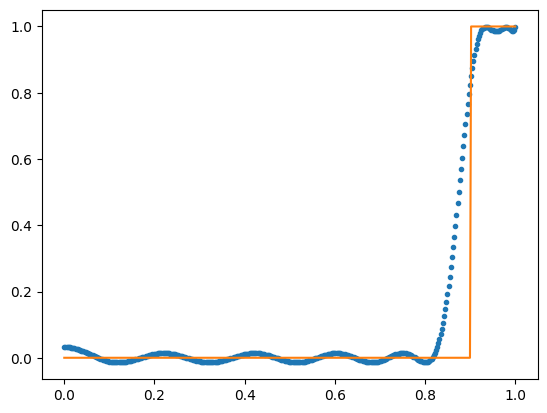

In [82]:
x = np.linspace(0,1,400)
y = np.polynomial.chebyshev.chebval(x, coefs.value)
plt.plot(x,y,'.')
sign = shifted_sign_function(x,mu-eta)
plt.plot(x,sign)

To get the symmetric phase factors we use another optimization problem based on the values of the polynomial at certain values $x_k$.

In [83]:
d_tilde = (d+2)/2
k = np.linspace(0,int(d_tilde)-1,int(d_tilde))
x_k = np.cos((2*k-1)/(4*d_tilde*np.pi))
F_xk = np.polynomial.chebyshev.chebval(x_k, coefs.value)

We also need to define function $g(x,\Phi)$, involving the phase factors, that's given by an expectation value:
$$g(x,\Phi):=\mathrm{Re}[\langle0|e^{i\phi_0Z}e^{i\arccos(x)X}e^{i\phi_1Z}e^{i\arccos(x)X}\cdots e^{i\phi_{d-1}Z}e^{i\arccos(x)X}e^{i\phi_dZ}|0\rangle]$$

In [84]:
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])


def g(x,angles):
    g = np.identity(2)
    acos = np.arccos(x)
    for i in range(len(angles)-1):
        g = g*np.exp(1j*angles[i]*Z)*np.exp(1j*acos*X)
    g = g*np.exp(1j*angles[-1]*Z)
    ket_0 = [1,0]
    g_00 = np.matmul(ket_0,np.matmul(g,ket_0))
    return np.real(g_00)

In [85]:
def F_phi(angles):
    sum = 0 
    for i in range(1,int(d_tilde)):
        sum += np.abs(g(x_k[i],angles) - F_xk[i])**2
    F_phi = sum/d_tilde
    return F_phi

In [86]:
init_guess = np.zeros(d)
init_guess[0] = np.pi/4
init_guess[-1] = np.pi/4

phases = opt.minimize(F_phi, init_guess).x

Now that we have the values for the phases that will be applied to the ancilla we can implement the QETU circuit.

In [87]:
def QETU_circuit(n_qubits,phases,steps):
    q = cirq.LineQubit.range(n_qubits+1) #last qubit selected as ancilla
    QETU_circuit = cirq.Circuit()
    tau =0.5
    for i in range(int(len(phases)/2)):
        QETU_circuit.append(np.exp(1j*phases[2*i]*cirq.X(q[-1])))
        QETU_circuit.append(KWK_step(n_qubits,tau,steps))
        QETU_circuit.append(np.exp(1j*phases[2*i+1]*cirq.X(q[-1])))
        QETU_circuit.append(cirq.X(q[-1]))
        QETU_circuit.append(KWK_step(n_qubits,tau,steps))
        QETU_circuit.append(cirq.X(q[-1]))
    return QETU_circuit
QETU_circuit(4,phases,3)

0: ─────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)────────────────ZZ───────────Rx(0.053π)─────────────────────────────PauliString(-iY)────────────────PauliString(-iY)───ZZ─────────Rx(0.053π)──────

In [90]:
def H(n_qubits):
    q = cirq.LineQubit.range(n_qubits) 
    op = 0
    op2 = 0
    g = 4

    for i in range(n_qubits-1):
        op += cirq.PauliString(-cirq.Z(q[i])*cirq.Z(q[i+1]))
    for i in range(n_qubits):
        op += cirq.PauliString(-g*cirq.X(q[i]))
        
    return op


In [89]:
n_qubits=2
trotter_steps = 3
simulator = cirq.Simulator()

simulator.simulate_expectation_values(QETU_circuit(n_qubits,phases,trotter_steps), H(2))

[(-0.8363364040851593-5.587935447692871e-09j)]